In [1]:
import os
import sys
import argparse
import logging
import bean as be
from bean.plotting.allele_stats import plot_n_alleles_per_guide, plot_n_guides_per_edit
import matplotlib.pyplot as plt

plt.style.use("default")

In [18]:
bdata_path = "/PHShome/jr1025//projects/ANBE/anbe_manuscript/workflow/results/filtered_annotated/LDLRCDS/bean_count_LDLRCDS_masked.h5ad"
out_bdata_path = bdata_path = "/PHShome/jr1025//projects/ANBE/anbe_manuscript/workflow/results/filtered_annotated/LDLRCDS/bean_count_LDLRCDS_alleleFiltered.h5ad"
plasmid_path = "/PHShome/jr1025//projects/ANBE/anbe_manuscript/workflow/results/mapped/LDLRCDS/bean_count_LDLRCDS_plasmid.h5ad"
edit_start_pos = 2
edit_end_pos = 7
filter_allele_proportion = 0.05
filter_sample_proportion = 0.2
jaccard_threshold = 0.5
output_prefix=bdata_path.rsplit(".h5ad", 1)[0] + "_alleleFiltered"

In [3]:
bdata = be.read_h5ad(bdata_path)

In [4]:
print(
    f"Starting from .uns['allele_counts'] with {len(bdata.uns['allele_counts'])} alleles."
)

Starting from .uns['allele_counts'] with 987700 alleles.


In [5]:
allele_df_keys = ["allele_counts"]

In [6]:
plasmid_adata = be.read_h5ad(plasmid_path)
plasmid_adata.uns[allele_df_keys[-1]] = plasmid_adata.uns[
    allele_df_keys[-1]
].loc[plasmid_adata.uns[allele_df_keys[-1]].allele.map(str) != "", :]

(q_val_each, sig_allele_df,) = be.an.filter_alleles.filter_alleles(
    bdata, plasmid_adata, filter_each_sample=True, run_parallel=True
)
bdata.uns["sig_allele_counts"] = sig_allele_df.reset_index(drop=True)
allele_df_keys.append("sig_allele_counts")
print(f"Filtered down to {len(bdata.uns['sig_allele_counts'])} alleles.")

Running Fisher's exact test to get significant edits compared to control...
Done calculating significance.


Filtering alleles for those containing significant edits (q < 0.05)...
Running 30 parallel processes to filter alleles...
Done filtering alleles, merging the result...


Mapping alleles to closest filtered alleles:   0%|          | 0/7469 [00:00<?, ?it/s]

Done!
Filtered down to 164593 alleles.


## Filter based on relative position within spcaer sequence

In [7]:
bdata.uns[f"{allele_df_keys[-1]}_spacer"] = bdata.filter_allele_counts_by_pos(
    rel_pos_start=0,
    rel_pos_end=20,
    rel_pos_is_reporter=False,
    map_to_filtered=True,
    allele_uns_key=allele_df_keys[-1],
    jaccard_threshold= jaccard_threshold,
).reset_index(drop=True)
print(
    f"Filtered down to {len(bdata.uns[f'{allele_df_keys[-1]}_spacer'])} alleles."
)
allele_df_keys.append(f"{allele_df_keys[-1]}_spacer")

160103 edits filtered from 164593 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/7257 [00:00<?, ?it/s]

Filtered down to 65568 alleles.


In [8]:
print(
    f"Filtering out edits based on relatvie position in spacer: 0-based [{edit_start_pos},{edit_end_pos})..."
)
filtered_key = (
    f"{allele_df_keys[-1]}_{ edit_start_pos}_{ edit_end_pos}"
)
bdata.uns[filtered_key] = bdata.filter_allele_counts_by_pos(
    rel_pos_start= edit_start_pos,
    rel_pos_end= edit_end_pos,
    rel_pos_is_reporter=False,
    map_to_filtered=True,
    allele_uns_key=allele_df_keys[-1],
    jaccard_threshold= jaccard_threshold,
).reset_index(drop=True)
allele_df_keys.append(filtered_key)
print(f"Filtered down to {len(bdata.uns[filtered_key])} alleles.")

Filtering out edits based on relatvie position in spacer: 0-based [2,7)...
86580 edits filtered from 65568 alleles.
mapping filtered alleles ...


Mapping alleles to closest filtered alleles:   0%|          | 0/7126 [00:00<?, ?it/s]

Filtered down to 10783 alleles.


## Translate alleles

In [9]:
print(
    "Translating alleles..."
)  # TODO: Check & document custom fasta file for translation
filtered_key = f"{allele_df_keys[-1]}_translated"
bdata.uns[filtered_key] = be.translate_allele_df(
    bdata.uns[allele_df_keys[-1]], 
).rename(columns={"allele": "aa_allele"})
allele_df_keys.append(filtered_key)
print(f"Filtered down to {len(bdata.uns[filtered_key])} alleles.")

Translating alleles...
ref:T at pos 1417, got edit 11224270:11:+:A>G
ref:C at pos 1415, got edit 11224268:9:+:A>G
ref:C at pos 1415, got edit 11224268:9:+:A>G
Cannot translate codon due to ambiguity: GG-
reached the end of CDS, frameshift.
reached the end of CDS, frameshift.
ref:T at pos 1958, got edit 11230881:11:+:C>G
ref:C at pos 1973, got edit 11230896:10:-:A>G
ref:C at pos 1973, got edit 11230896:11:-:A>G
Cannot translate codon due to ambiguity: T-C
ref:A at pos 2231, got edit 11233941:10:-:C>T
ref:A at pos 2231, got edit 11233941:10:-:C>T
ref:C at pos 2248, got edit 11233958:9:-:A>G
reached the end of CDS, frameshift.
reached the end of CDS, frameshift.
reached the end of CDS, frameshift.
reached the end of CDS, frameshift.
reached the end of CDS, frameshift.
reached the end of CDS, frameshift.
reached the end of CDS, frameshift.
reached the end of CDS, frameshift.
reached the end of CDS, frameshift.
reached the end of CDS, frameshift.
reached the end of CDS, frameshift.
reached 

## Filter by allele proportion

In [10]:
print(
    f"Filtering alleles for those have allele fraction {filter_allele_proportion} in at least {filter_sample_proportion*100}% of samples..."
)
filtered_key = f"{allele_df_keys[-1]}_prop{filter_allele_proportion}_{filter_sample_proportion}"
bdata.uns[filtered_key] = be.an.filter_alleles.filter_allele_prop(
    bdata,
    allele_df_keys[-1],
    allele_prop_thres=filter_allele_proportion,
    sample_prop_thres=filter_sample_proportion,
    map_to_filtered=True,
    retain_max=True,
    allele_col=bdata.uns[allele_df_keys[-1]].columns[1],
    distribute=True,
    jaccard_threshold=jaccard_threshold,
)
allele_df_keys.append(filtered_key)
print(f"Filtered down to {len(bdata.uns[filtered_key])} alleles.")

Filtering alleles for those have allele fraction 0.05 in at least 20.0% of samples...


  0%|          | 0/5169 [00:00<?, ?it/s]

Mapping filtered alleles...


Mapping alleles to closest filtered alleles:   0%|          | 0/5169 [00:00<?, ?it/s]

Filtered down to 6657 alleles.


In [14]:
allele_df_keys

['allele_counts',
 'sig_allele_counts',
 'sig_allele_counts_spacer',
 'sig_allele_counts_spacer_2_7',
 'sig_allele_counts_spacer_2_7_translated',
 'sig_allele_counts_spacer_2_7_translated_prop0.05_0.2']

In [13]:
filter_sample_proportion  = 0.1

In [15]:
print(
    f"Filtering alleles for those have allele fraction {filter_allele_proportion} in at least {filter_sample_proportion*100}% of samples..."
)
filtered_key = f"{allele_df_keys[-2]}_prop{filter_allele_proportion}_{filter_sample_proportion}"
bdata.uns[filtered_key] = be.an.filter_alleles.filter_allele_prop(
    bdata,
    allele_df_keys[-2],
    allele_prop_thres=filter_allele_proportion,
    sample_prop_thres=filter_sample_proportion,
    map_to_filtered=True,
    retain_max=True,
    allele_col=bdata.uns[allele_df_keys[-2]].columns[1],
    distribute=True,
    jaccard_threshold=jaccard_threshold,
)
allele_df_keys.append(filtered_key)
print(f"Filtered down to {len(bdata.uns[filtered_key])} alleles.")

Filtering alleles for those have allele fraction 0.05 in at least 10.0% of samples...


  0%|          | 0/5169 [00:00<?, ?it/s]

Mapping filtered alleles...


Mapping alleles to closest filtered alleles:   0%|          | 0/5169 [00:00<?, ?it/s]

Filtered down to 7340 alleles.


# Plot filtering steps

Saving plotting result and log at /PHShome/jr1025//projects/ANBE/anbe_manuscript/workflow/results/filtered_annotated/LDLRCDS/bean_count_LDLRCDS_masked_alleleFiltered.[filtered_allele_stats.pdf, filter_log.txt].


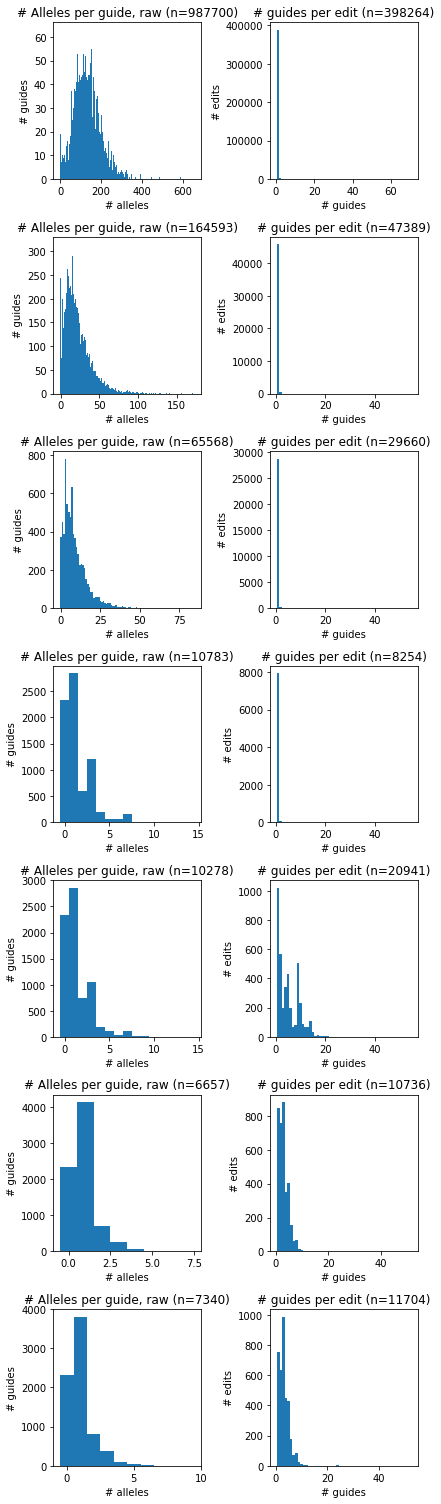

In [16]:
fig, ax = plt.subplots(len(allele_df_keys), 2, figsize=(6, 3 * len(allele_df_keys)))
for i, key in enumerate(allele_df_keys):
    plot_n_alleles_per_guide(bdata, key, bdata.uns[key].columns[1], ax[i, 0])
    plot_n_guides_per_edit(bdata, key, bdata.uns[key].columns[1], ax[i, 1])
plt.tight_layout()
plt.savefig(f"{ output_prefix}.filtered_allele_stats.pdf", bbox_inches="tight")
print(
    f"Saving plotting result and log at { output_prefix}.[filtered_allele_stats.pdf, filter_log.txt]."
)

# Write log

In [17]:
with open(f"{output_prefix}.filter_log.txt", "w") as out_log:
    for key in allele_df_keys:
        out_log.write(f"{key}\t{len(bdata.uns[key])}\n")

## Save result

In [19]:
bdata.write(out_bdata_path)

In [20]:
bdata.guides

,Region,pos,strand,sequence,Reporter,barcode,5-nt PAM,targetPos,pos_seq,guide_len,start_pos,target_start,masked_sequence,masked_barcode,Group,edit_rate
name,,,,,,,,,,,,,,,,
5' UTR+pro_28_neg,5' UTR+pro,28,neg,TCCTTCGAAAGTGTCGCCAG,CTCCAGTCCTTCGAAAGTGTCGCCAGGGCAGG,CCTC,GGCAG,11199966.0,CTGGCGACACTTTCGAAGGA,20,11199952,5.0,TCCTTCGGGGGTGTCGCCGG,CCTC,5' UTR+pro,NaN
5' UTR+pro_28_pos,5' UTR+pro,28,pos,CTTTCGAAGGACTGGAGTGG,GCGACACTTTCGAAGGACTGGAGTGGGAATCA,CAAA,GAATC,11199966.0,CTTTCGAAGGACTGGAGTGG,20,11199961,5.0,CTTTCGGGGGGCTGGGGTGG,CGGG,5' UTR+pro,0.323475
5' UTR+pro_31_neg,5' UTR+pro,31,neg,CAGTCCTTCGAAAGTGTCGC,CCACTCCAGTCCTTCGAAAGTGTCGCCAGGGC,CCTA,CAGGG,11199969.0,GCGACACTTTCGAAGGACTG,20,11199955,5.0,CGGTCCTTCGGGGGTGTCGC,CCTG,5' UTR+pro,NaN
5' UTR+pro_31_pos,5' UTR+pro,31,pos,TCGAAGGACTGGAGTGGGAA,ACACTTTCGAAGGACTGGAGTGGGAATCAGAG,TGCC,TCAGA,11199969.0,TCGAAGGACTGGAGTGGGAA,20,11199964,5.0,TCGGGGGGCTGGGGTGGGGG,TGCC,5' UTR+pro,0.026911
5' UTR+pro_34_neg,5' UTR+pro,34,neg,CTCCAGTCCTTCGAAAGTGT,TTCCCACTCCAGTCCTTCGAAAGTGTCGCCAG,CTGA,CGCCA,11199972.0,ACACTTTCGAAGGACTGGAG,20,11199958,5.0,CTCCGGTCCTTCGGGGGTGT,CTGG,5' UTR+pro,0.340677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CBE_CONTROL_40_pos,CBE control,40,NaN,TATCGCGCTTGGGTTATACG,GAAAAATATCGCGCTTGGGTTATACGCTCCAA,TACC,CTCCA,NaN,TATCGCGCTTGGGTTATACG,20,-1,NaN,TGTCGCGCTTGGGTTGTGCG,TGCC,CBE control,NaN
CBE_CONTROL_96_pos,CBE control,96,NaN,ATTAGCCGTTGCCATATCAA,TCCGTTATTAGCCGTTGCCATATCAAATGAGA,GCTC,ATGAG,NaN,ATTAGCCGTTGCCATATCAA,20,-1,NaN,GTTGGCCGTTGCCGTGTCGG,GCTC,CBE control,0.772672
CBE_CONTROL_97_pos,CBE control,97,NaN,GTCCCTCAGGGTGCAACTT,TCTAAGGGTCCCTCAGGGTGCAACTTTGGTAC,AGAA,TGGTA,NaN,GTCCCTCAGGGTGCAACTT,19,-1,NaN,GTCCCTCGGGGTGCGGCTT,GGGG,CBE control,NaN


In [ ]:
# Plot